In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.autograd import Variable

print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


In [2]:
img_size = 100
batch_size = 32
use_cuda = torch.cuda.is_available()

# Load datasets

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(img_size),
        transforms.CenterCrop(img_size),
        # transforms.RandomSizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(img_size),
        transforms.CenterCrop(img_size),
        #transforms.RandomSizedCrop(img_size),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
train_dataset = datasets.ImageFolder('data/train', data_transforms['train'])
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

val_dataset = datasets.ImageFolder('data/val', data_transforms['val'])
val_data = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [36]:
class_names = train_dataset.classes
class_names

['cats', 'dogs']

Shape of images in the batch: torch.Size([32, 3, 100, 100])
First image plot:
Img target: 0, Class: cats


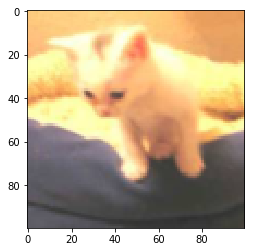

In [4]:
# batch = next(iter(val_data))
batch = next(iter(train_data))
print("Shape of images in the batch: " + str(batch[0].shape))
print("First image plot:")
img = batch[0][0].numpy().transpose(1,2,0)
plt.imshow(img)
print("Img target: {}, Class: {}".format(batch[1][0], 
                                  class_names[batch[1][0]]))

# Model

You can list Pytorch vgg16 model information with following command

    models.vgg16(pretrained=True)

Default vgg16 model would be fine by itself if we use 224x224 pixel sizes but now for practice lets define classifier by ourself.

In [6]:
class Model(nn.Module):
    def __init__(self, img_size, num_classes=2, pretrained_vgg=True):
        super(Model, self).__init__()

        vgg_model = models.vgg16(pretrained=pretrained_vgg)
        self.vgg_base_model = list(vgg_model.children())[0]
        # Let's do a single forward pass to calculate vgg_base_model output size
        forward_pass_sample = self.vgg_base_model(Variable(torch.ones(1, 3, img_size, img_size)))
        self.vgg_base_output_size = int(np.prod(forward_pass_sample.size()))

        self.top_model = nn.Sequential(nn.Linear(self.vgg_base_output_size, 4096),
                                                  nn.ReLU(),
                                                  nn.Linear(4096, 4096),
                                                  nn.ReLU(),
                                                  nn.Dropout(p=0.5),
                                                  nn.Linear(4096, 4096),
                                                  nn.ReLU(),
                                                  nn.Dropout(p=0.5),
                                                  nn.Linear(4096, 2),
                                                 )
        
    def forward(self, x):
        out = self.vgg_base_model(x)
        out = out.view(-1, self.vgg_base_output_size)
        out = self.top_model(out)
        return out

In [7]:
model = Model(img_size)

In [8]:
# Do not train base model parameters
for param in model.vgg_base_model.parameters():
    param.requires_grad = False
#for param in model.parameters():
#    print(param.requires_grad)

In [9]:
model

Model (
  (vgg_base_model): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [10]:
# testing that model works with one batch
model(Variable(next(iter(train_data))[0][0:1]))

Variable containing:
1.00000e-02 *
 -6.8970  2.9380
[torch.FloatTensor of size 1x2]

In [11]:
model = model.cuda()

### Accuracy testing

In [12]:
def test_model_accuracy(model, data_loader, use_cuda=False):
    model.eval() # Set model in evaluation mode so dropout etc won't affect
    test_loss, correct = 0, 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(data_loader.dataset)
    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)'.format(
                test_loss, correct, len(data_loader.dataset),
                100. * correct / len(data_loader.dataset)))

In [13]:
%%time
test_model_accuracy(model, val_data, use_cuda=use_cuda)

Test set: Average loss: 0.694251, Accuracy: 1139/2500 (45.56%)
CPU times: user 1.86 s, sys: 468 ms, total: 2.33 s
Wall time: 2.72 s


### Training the model

In [14]:
def train_epoch(model, data_loader, optimizer, log_interval_percentage=.35, use_cuda=False):
    model.train()
    train_loss = []
    log_interval = int((len(data_loader.dataset)/data_loader.batch_size) * log_interval_percentage)
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data = Variable(data)
        target = Variable(target)
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        predict = model(data)
        loss = F.cross_entropy(predict, target)
        train_loss.append(loss.data[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx % log_interval == 0) and (batch_idx > 0):
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(data_loader.dataset),
                        100. * batch_idx / len(data_loader), np.average(train_loss)))
    print(("Epoch: {}, Loss: {:.6f}").format(epoch , np.average(train_loss)))

In [15]:
total_epochs = 0

In [16]:
%%time
# note that we give optimizer only the parameters we wan't to train
optimizer = torch.optim.Adam(model.top_model.parameters(), lr=0.001)
for epoch in range(10):
    total_epochs += 1
    train_epoch(model, train_data, optimizer, use_cuda=True)
    test_model_accuracy(model, val_data, use_cuda=True)
print()

Epoch: 0 [1728/5000 (34%)]	Loss: 0.698964
Epoch: 0 [3456/5000 (69%)]	Loss: 0.462856
Epoch: 0, Loss: 0.386730
Test set: Average loss: 0.200261, Accuracy: 2300/2500 (92.00%)
Epoch: 1 [1728/5000 (34%)]	Loss: 0.143786
Epoch: 1 [3456/5000 (69%)]	Loss: 0.154095
Epoch: 1, Loss: 0.167424
Test set: Average loss: 0.207432, Accuracy: 2285/2500 (91.40%)
Epoch: 2 [1728/5000 (34%)]	Loss: 0.142820
Epoch: 2 [3456/5000 (69%)]	Loss: 0.143828
Epoch: 2, Loss: 0.150835
Test set: Average loss: 0.226472, Accuracy: 2294/2500 (91.76%)
Epoch: 3 [1728/5000 (34%)]	Loss: 0.092839
Epoch: 3 [3456/5000 (69%)]	Loss: 0.104528
Epoch: 3, Loss: 0.110163
Test set: Average loss: 0.248289, Accuracy: 2279/2500 (91.16%)
Epoch: 4 [1728/5000 (34%)]	Loss: 0.096995
Epoch: 4 [3456/5000 (69%)]	Loss: 0.114823
Epoch: 4, Loss: 0.118270
Test set: Average loss: 0.227450, Accuracy: 2287/2500 (91.48%)
Epoch: 5 [1728/5000 (34%)]	Loss: 0.108779
Epoch: 5 [3456/5000 (69%)]	Loss: 0.100474
Epoch: 5, Loss: 0.098977
Test set: Average loss: 0.35300

In [17]:
test_model_accuracy(model, val_data, use_cuda=True)

Test set: Average loss: 0.523033, Accuracy: 2311/2500 (92.44%)


# Some sample predictions

In [33]:
batch = next(iter(val_data))[0][0:6]
results = model(Variable(batch).cuda())

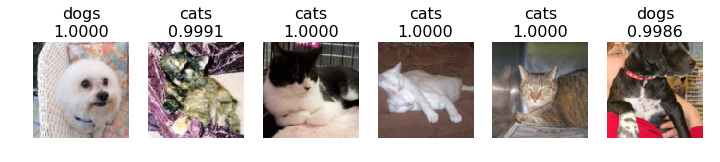

In [35]:
f = plt.figure(figsize=(12,5))
for i in range(len(results)):
    img = batch[i].numpy().transpose(1,2,0)
    class_idx = results[i].max(0)[1].data[0]
    score = F.softmax(results[i])[class_idx].data[0]
    img_title = "{}\n{:.4f}".format(class_names[class_idx], score)
    sp = f.add_subplot(1, len(batch), i+1)
    sp.axis('Off')
    sp.set_title(img_title, fontsize=16)
    plt.imshow(img)